## Import libraries

In [1]:
# standard packages
import numpy as np
import pandas as pd

# visualisation packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# DL packages - tensorflow, keras, model
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
        
# warnings
import scipy
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# defined path for uploading the data to Kaggle
for dirname, _, filenames in os.walk('/kaggle/Users/mac/Desktop/WK9/9_7_Transfer_Learning/train_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Loading the model - MobileNetV2

In [2]:
def image_resize(image_path):
    img = image.load_img(image_path, target_size=(224,224))
    return img

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
 
def image_preprocessing(resized_image):
    pic_array = image.img_to_array(resized_image)
    image_batch = np.expand_dims(pic_array, axis=0)
    processed_image = preprocess_input(image_batch)
    return processed_image

In [4]:
def image_class_prediction(model, preprocessed_image):
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {'image_class': [_[1] for _ in decoded_prediction],
            'probability': [_[2] for _ in decoded_prediction]
           }
    df = pd.DataFrame(data=data)
    return df

## Instantiation of the model

In [5]:
pretrained_model = MobileNetV2(weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


## Summary of the model

In [6]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Evaluation of the model

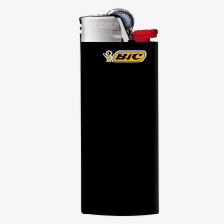

In [7]:
# resize and view of the image
resized_image = image_resize('../input/test-data/test_data/Lighter_02.png')
resized_image

In [8]:
# preprocessing
preprocessed_img = image_preprocessing(resized_image)

# class prediction
image_class_prediction(pretrained_model, preprocessed_img)

49152/35363 [=========================================] - 0s 0us/step


,image_class,probability
0,lighter,0.769364
1,ashcan,0.069646
2,punching_bag,0.036939
3,can_opener,0.036312
4,perfume,0.006171


## Transfer Learning Phase

In [9]:
# folder names for classes
classes = os.listdir('../input/train-data/train_data')
classes

['Tic-tac', 'Airpods', 'Lighter', 'Toothpick']

In [10]:
# image data generator
data_gen = keras.preprocessing.image.ImageDataGenerator(
    # preprocessing function to be applied to all images
    preprocessing_function=preprocess_input
)

In [11]:
# defining batch size for a X,y arrays generator 
train_data_gen = data_gen.flow_from_directory(
        directory='../input/train-data/train_data',
        class_mode="categorical",
        classes=classes,
        batch_size=396,
        target_size=(224, 224)
)

Found 396 images belonging to 4 classes.


In [12]:
# loading of all of the images
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((396, 224, 224, 3), (396, 4))

## Model Construction

In [13]:
base_model = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,         
    pooling='avg',      
    include_top=False,  
    input_shape=(224, 224, 3)
)

# model needs to be frozen
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Addition of the top Dense layer

In [15]:
def model_builder(hp):
    
    # Initialize the Sequential API and start stacking the layers
    model = keras.Sequential()
    model.add(base_model)
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-160
    hp_units = hp.Int('units', min_value=32, max_value=160, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Add next layers
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(len(classes), activation='softmax'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

### 3.2 Hyperparameter Tuning

In [16]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, 
                     objective='val_categorical_accuracy', 
                     max_epochs=50,
                     hyperband_iterations=3,
                     project_name='tuning_results')

In [17]:
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [18]:
# Perform hypertuning
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tf.autograph.experimental.do_not_convert
tuner.search(xtrain, ytrain,
             epochs=50,
             batch_size=16,
             callbacks=[stop_early],
             validation_split=1/6)

Trial 15 Complete [00h 00m 05s]
val_categorical_accuracy: 1.0

Best val_categorical_accuracy So Far: 1.0
Total elapsed time: 00h 01m 23s


In [19]:
# best hyperparameters
best_hp=tuner.get_best_hyperparameters(1)[0]

In [20]:
# Building the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                81984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 2,340,228
Trainable params: 82,244
Non-trainable params: 2,257,984
_________________________________________________________________


## Training of the model

In [21]:
tf.autograph.experimental.do_not_convert
h_model.fit(xtrain, ytrain,
            epochs=50,
            batch_size=16,
            callbacks=[stop_early],
            validation_split=1/6)

Epoch 1/50
21/21 [==============================] - 3s 63ms/step - loss: 0.7924 - categorical_accuracy: 0.7848 - val_loss: 8.9517e-04 - val_categorical_accuracy: 1.0000
Epoch 2/50
21/21 [==============================] - 0s 23ms/step - loss: 0.0780 - categorical_accuracy: 0.9606 - val_loss: 0.0023 - val_categorical_accuracy: 1.0000
Epoch 3/50
21/21 [==============================] - 0s 23ms/step - loss: 0.0883 - categorical_accuracy: 0.9576 - val_loss: 0.0048 - val_categorical_accuracy: 1.0000
Epoch 4/50
21/21 [==============================] - 0s 23ms/step - loss: 0.0365 - categorical_accuracy: 0.9848 - val_loss: 2.5196e-06 - val_categorical_accuracy: 1.0000
Epoch 5/50
21/21 [==============================] - 0s 23ms/step - loss: 0.0111 - categorical_accuracy: 1.0000 - val_loss: 4.2205e-05 - val_categorical_accuracy: 1.0000
Epoch 6/50
21/21 [==============================] - 1s 28ms/step - loss: 0.0674 - categorical_accuracy: 0.9727 - val_loss: 7.5274e-05 - val_categorical_accuracy: 1

In [22]:
losses = pd.DataFrame(h_model.history.history)
epoch = losses.index.values + np.ones_like(losses.index.values) 
loss = losses['loss'].values 
val_loss = losses['val_loss'].values 

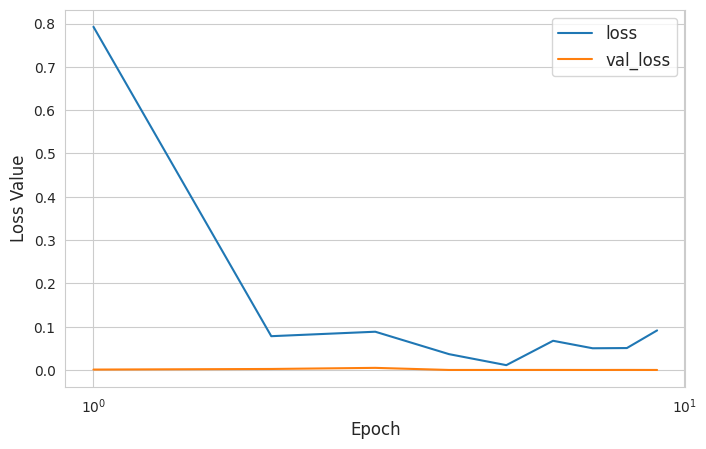

In [23]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss Value',fontsize=12)
plt.legend(loc=1,fontsize=12)
None

## Evaluation of the model

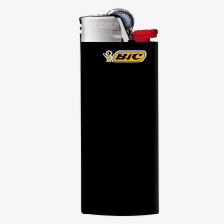

In [24]:
# resize and show image
resized_image = image_resize('../input/test-data/test_data/Lighter_02.png')
resized_image

In [25]:
# preprocess an image
preprocessed_img = image_preprocessing(resized_image)

In [26]:
def image_classification(preprocessed_image, model):
    probs = model.predict(preprocessed_image)[0].tolist()
    zipped = sorted(list(zip(classes, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    return df

In [27]:
tf.autograph.experimental.do_not_convert
image_classification(preprocessed_img, h_model)

,image_class,probability(%)
0,Lighter,99.988317
1,Tic-tac,0.011276
2,Airpods,0.000398
3,Toothpick,0.000009
